In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [80]:

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    # print("Add")
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out
  
#   def __subtract__(self, other):
#     other = other if isinstance(other, Value) else Value(other)
#     out = Value(self.data - other.data, (self, other), '-')
    
#     def _backward():
#       self.grad += 1.0 * out.grad
#       other.grad += 1.0 * out.grad
#     out._backward = _backward
    
#     return out

  def __mul__(self, other):
    # print("MUL")
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    # print("RMUL")
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    # print("Rsub")
    return self + (-other)

  def __radd__(self, other): # other + self
    # print("Radd")
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [9]:
# letter.grad= dL/d(letter)
L.grad=1.00
f.grad=d.data
d.grad=f.data

c.grad=(d.grad)*1.0
e.grad=(d.grad)*1.0

a.grad=(e.grad)*b.data
b.grad=e.grad*a.data


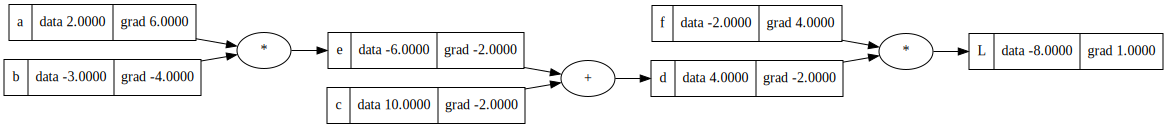

In [10]:
draw_dot(L)

CS231n convolution neural network for visual recognition




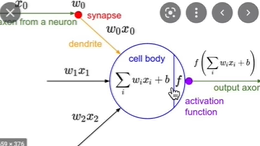


where f = tan(h)

Wi are the weights of the intial inputs

b = bias function

In [11]:
x1=Value(2.0, label='x1')
x2=Value(0.0, label = 'x2')

w1=Value(-3.0, label='w1')
w2=Value(1.0 , label ='w2')

b=Value(6.8813735870195432, label='b')

x1w1=x1*w1; x1w1.label='x1w1'
x2w2=x2*w2; x2w2.label='x2w2'
x1w1x2w2= x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n=x1w1x2w2 + b; n.label='n'
o=n.tanh();o.label='o'



d(tanh)/dh = 1 - tanh**2

do/dn=1-o.data**2

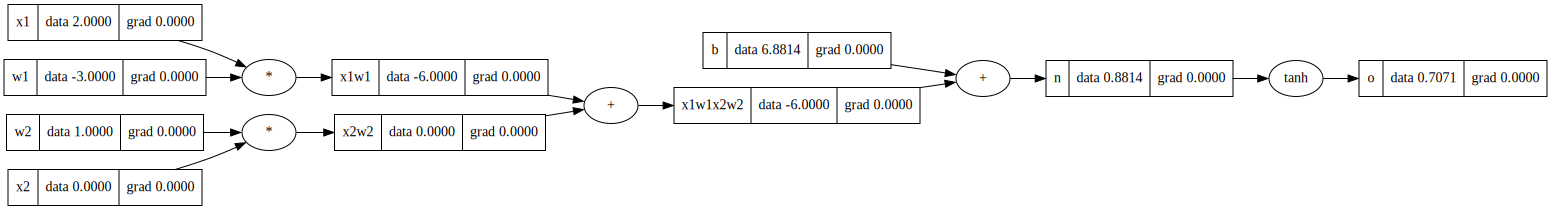

In [12]:
draw_dot(o)


In [13]:
o.backward()

In [14]:
a=Value(-2.0, label = 'a')
b=Value(3.0, label='b')
e=a+b;e.label='e'
d=a*b;d.label='d'
f=d*e;f.label='f'


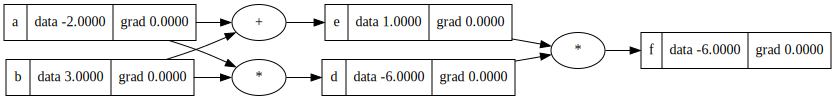

In [15]:
draw_dot(f)

In [16]:
f.backward()

Creating a multi layer perceptron with 2 hidden layers

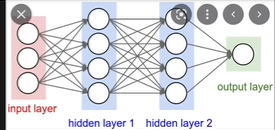

Each Neuron is a summation of Xi*Wi + b


In [91]:


class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) #zip pairs up Wi,Xi and is a 2x(nin) list  
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]
  


class Layer:
  def __init__(self, nin, nout): # nin equal to number of XiWi, nout equal to number of neurons in a layer
    self.neurons=[Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs=[n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs
  
  def parameters(self):
    # params=[]
    # for neuron in self.neurons:
    #   ps=neuron.parameters()
    #   params.extend(ps)
    # return params
    return [p for neuron in self.neurons for p in neuron.parameters()]


    
  

class MLP:
  def __init__(self, nin, nouts):
    sz=[nin]+nouts
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x=layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
  



x=[2.0,3.0,-1.0]
n=MLP(3, [4,4,1])
n(x)





Value(data=-0.7608722277735751)

In [93]:
len(n.parameters()) #number of weights and biases in the multi layer perceptron 

41

In [98]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
                     ] # 4 different values passed into the MLP

ys = [1.0, -1.0 , -1.0, 1.0] #desired targets




In [107]:
no_iterations = 25
for i in range(no_iterations):
     
     #forward pass
     ypred = [n(x) for x in xs]
     loss=sum(( ypredi-ysi)**2 for ysi, ypredi in zip(ys, ypred))

     #backward pass
     for p in n.parameters():
          p.grad=0.0
     loss.backward()

     #update
     for p in n.parameters():
        learning_rate=0.01
        p.data += -(learning_rate * p.grad) # negative because gradient gives the direction of the deviation from the value 
                                            # we want and we want to oppose to get closer to ys so we multiply negative 
     print(i, loss.data)





0 0.012244615306321753
1 0.012192135665175753
2 0.01214007776675245
3 0.012088436697885983
4 0.012037207619981257
5 0.01198638576762404
6 0.011935966447221587
7 0.0118859450356731
8 0.011836316979069339
9 0.011787077791420623
10 0.011738223053412405
11 0.011689748411188083
12 0.011641649575157665
13 0.011593922318832495
14 0.011546562477684706
15 0.011499565948031277
16 0.01145292868594169
17 0.011406646706168847
18 0.011360716081102739
19 0.011315132939745967
20 0.011269893466711037
21 0.011224993901238513
22 0.011180430536235741
23 0.011136199717335676
24 0.011092297841975088


In [108]:
ypred

[Value(data=0.962945230666751),
 Value(data=-0.971034965084682),
 Value(data=-0.9406289257927422),
 Value(data=0.9268197826495064)]